In [1]:
from glob import glob
import json
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
import random
import orjson as json
import numpy as np
from scipy.spatial import KDTree
import seaborn as sns

In [2]:
data = []
import json

with open('hansard.jsonl') as fopen:
    for x in fopen:
        data.append(json.loads(x))

In [3]:
vectors, texts = [], []

for d in data:
    vectors.append(d["v"])
    texts.append(d["text"])

In [4]:
data[0]['text']

{'ms': '\n128 DR.14.4.2010 \n \nhuraikan. Apa yang penting ialah Jawatankuasa ini adalah seperti namanya, \nfungsinya dicerminkan di dalam namanya untuk mempromosikan \npersefahaman dan keharmonian. Kalau diberi kuasa perundangan, maka ianya \nmenjadi satu aspek seperti yang telah dibangkitkan oleh Yang Berhormat \nTelok Intan sendiri.  \n\n Nampaknya Yang Berhormat Telok Intan bercanggah, pada satu pihak \ndi kata mesti ada kuasa perundangan dan kepada pihak satu lagi, beliau cuba \nhendak menyokong atau menyuarakan kebimbangan khasnya daripada \nbadan-badan Islam, bahawa Jawatankuasa seumpama ini tidak sepatutnya \nmempunyai kuasa perundangan kerana fungsinya adalah untuk berdialog. Itu \nsahaja, walaupun itu penting. Sekiranya hasil daripada perbincangan itu ada \napa-apa yang menyentuh tentang perkara-perkara perundangan, ia akan \ndibawa oleh pegawai-pegawai kanan dari JAKIM, IKIM dan JPNIN ke \nperhatian Jemaah Menteri untuk pertimbangan.  \n\n Dato’ Haji Ismail bin Mohamed Said 

In [5]:
texts[0]

{'ms': '\n128 DR.14.4.2010 \n \nhuraikan. Apa yang penting ialah Jawatankuasa ini adalah seperti namanya, \nfungsinya dicerminkan di dalam namanya untuk mempromosikan \npersefahaman dan keharmonian. Kalau diberi kuasa perundangan, maka ianya \nmenjadi satu aspek seperti yang telah dibangkitkan oleh Yang Berhormat \nTelok Intan sendiri.  \n\n Nampaknya Yang Berhormat Telok Intan bercanggah, pada satu pihak \ndi kata mesti ada kuasa perundangan dan kepada pihak satu lagi, beliau cuba \nhendak menyokong atau menyuarakan kebimbangan khasnya daripada \nbadan-badan Islam, bahawa Jawatankuasa seumpama ini tidak sepatutnya \nmempunyai kuasa perundangan kerana fungsinya adalah untuk berdialog. Itu \nsahaja, walaupun itu penting. Sekiranya hasil daripada perbincangan itu ada \napa-apa yang menyentuh tentang perkara-perkara perundangan, ia akan \ndibawa oleh pegawai-pegawai kanan dari JAKIM, IKIM dan JPNIN ke \nperhatian Jemaah Menteri untuk pertimbangan.  \n\n Dato’ Haji Ismail bin Mohamed Said 

In [4]:
concat = np.array(vectors)
concat.shape

(137730, 1024)

In [5]:
%%time

kd_tree = KDTree(concat, leafsize = 40)

CPU times: user 1.19 s, sys: 7.51 ms, total: 1.2 s
Wall time: 1.2 s


In [23]:
%%time

dist, ind = kd_tree.query(concat[:1000], k=len(concat), workers = 1000)

CPU times: user 8min 16s, sys: 4min 6s, total: 12min 22s
Wall time: 1min 5s


In [24]:
dist

array([[0.        , 0.36564006, 0.36687821, ..., 0.735345  , 0.73927077,
        0.74077084],
       [0.        , 0.39924248, 0.40156597, ..., 0.81288611, 0.81994712,
        0.83406327],
       [0.        , 0.45639592, 0.4571287 , ..., 0.80178552, 0.80770785,
        0.81379452],
       ...,
       [0.        , 0.34768689, 0.34846541, ..., 0.75599058, 0.76095336,
        0.76455013],
       [0.        , 0.28597266, 0.29847608, ..., 0.74183351, 0.74391722,
        0.7460333 ],
       [0.        , 0.35721956, 0.35930973, ..., 0.76913111, 0.76919376,
        0.77949754]])

/tmp/ipykernel_479945/3913103053.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dist)


<Axes: ylabel='Density'>

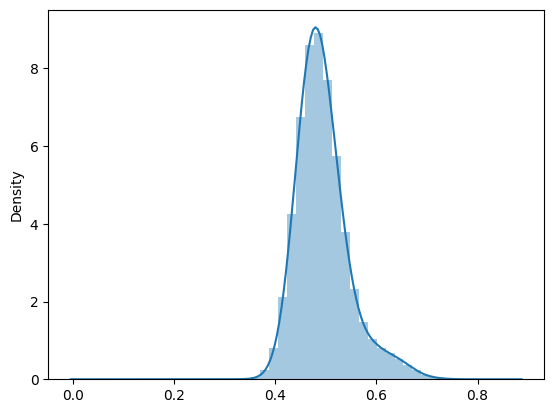

In [25]:
sns.distplot(dist)

In [53]:
dist[dist > 0.7].shape

(293636,)

In [48]:
dist[dist < 0.4].shape

(1795326,)

In [47]:
dist.shape

(1000, 137730)

In [50]:
concat.shape

(137730, 1024)

In [21]:
dist[dist > 0.75].shape

(10221,)

In [19]:
dist[dist < 0.35].shape

(20963,)

In [6]:
keys = list(texts[0].keys())
keys

['ms', 'en']

In [7]:
# !wget https://gist.githubusercontent.com/huseinzol05/98974ae8c6c7a65d4bc0af9f5003786a/raw/5aa5257608b61e8fcc828e99fbd070d5ca7358e3/mp.py
import mp

def dedup(strings):
    unique_neg = []
    elements = set()

    for n in strings:
        x_lower = n.lower()
        if x_lower not in elements:
            elements.add(x_lower)
            unique_neg.append(n)
    return unique_neg

dedup(['a', 'a'])

['a']

In [8]:
import time

lower_bound = 0.4
upper_bound = 0.7

def loop(data):
    data, index = data
    with open(f'hansard/hansard-train-dataset-{index}.jsonl', 'w') as fopen:
        for x in tqdm(data):
            dist, ind = kd_tree.query(concat[x], k=len(concat), workers = 1)

            for key in keys:

                query = texts[x][key]

                pos_indices = [k for k in ind[dist <= lower_bound]]
                neg_indices = [k for k in ind[dist >= upper_bound]]

                if len(neg_indices) > 5:
                    neg_indices = random.sample(neg_indices,5)
                if len(pos_indices) > 5:
                    rand_pos = random.sample(pos_indices,4)
                    rand_pos.append(x)
                    pos_indices = rand_pos


                pos = [value for i in pos_indices for value in texts[i].values() if value != query ]

                neg = [value for i in neg_indices for value in texts[i].values()]
                
                d = {"query":query,"pos":dedup(pos),"neg":dedup(neg)}
#                 print(d)
                fopen.write(f"{json.dumps(d)}\n")
#                 fopen.write(f"{json.dumps(d).decode()}\n")
                fopen.flush()

In [ ]:
import mp

mp.multiprocessing(range(len(data)), loop, cores = 30, returned = False)

  9%|▉         | 402/4591 [04:46<1:34:34,  1.35s/it]